In [10]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Load the dataset (assuming only one file is uploaded)
data = pd.read_csv(list(uploaded.keys())[0])

In [ ]:
# Check the first few rows
print(data.head())
print(data.describe())

# Check for missing values and data types
print(data.info())

# Check for missing values in each column
data.isnull().sum().max()

print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V28  Amount  Class  scaled_Amount  \
0  0.098698  0.363787  ... -0.021053  149.62      0       0.244964   
1  0.085102 -0.255425  ...  0.014724    2.69      0      -0.342475   
2  0.247676 -1.514654  ... -0.059752  378.66      0       1.160686   
3  0.377436 -1.387024  ...  0.061458  123.50      0       0.140534   
4 -0.270533  0.817739  ...  0.215153   69.99      0      -0.073403   

   scaled_Time  Hour  Amount_Bucket_1  Amount_Bucket_2  Amount_Bucket_3  \
0    -1.996583  2

<ipython-input-11-8c49ec51ec88>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=data, palette=colors, legend=False)


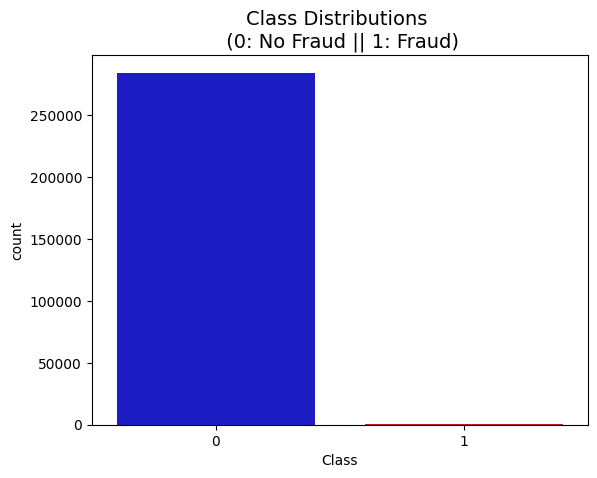

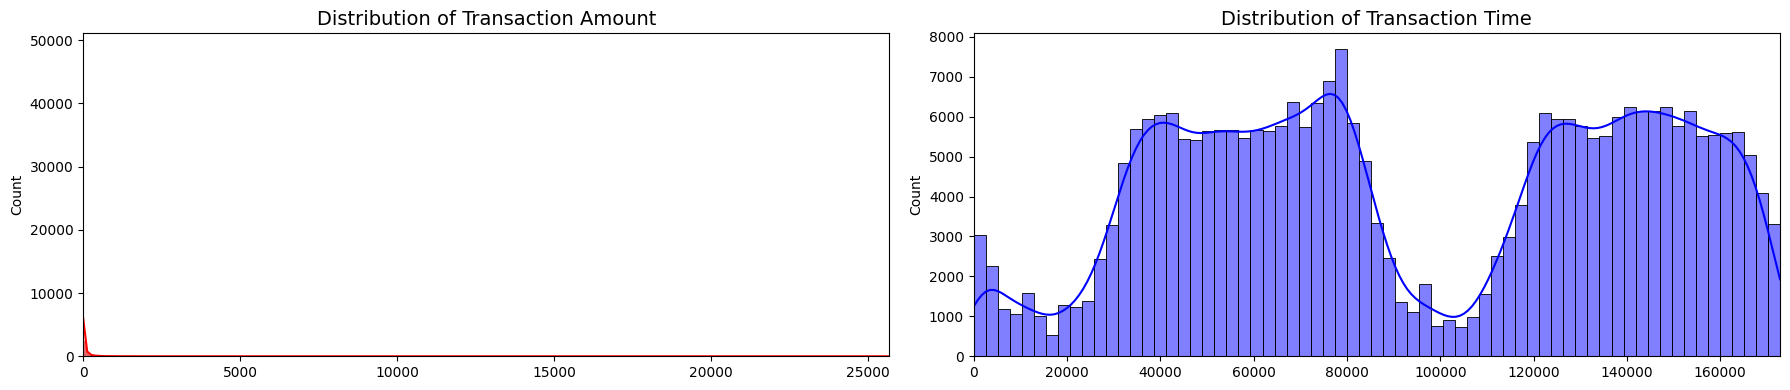

In [ ]:
# Visual representation of the dataset
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]

# Countplot with updated parameters
sns.countplot(x='Class', data=data, palette=colors, legend=False)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

# Subplots for histograms
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

amount_val = data['Amount'].values
time_val = data['Time'].values

# Histogram for transaction amount
sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

# Histogram for transaction time
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Preprocessing

# Standardize 'Amount' and 'Time'
amount_scaler = StandardScaler()
time_scaler = StandardScaler()
data['scaled_Amount'] = amount_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_Time'] = time_scaler.fit_transform(data['Time'].values.reshape(-1,1))

# Verify the standardization
print(data[['Time', 'Amount', 'scaled_Time' , 'scaled_Amount']].head())

# Step 2: Feature Engineering - Add 'Hour' and 'Amount_Bucket'
data['Hour'] = (data['scaled_Time'] // 3600) % 24

# Since we scaled 'Amount', we need to calculate percentiles and accordingly assign labels to 'Amount_Bucket'
percentiles = np.percentile(data['scaled_Amount'], [25, 50, 75, 95])
data['Amount_Bucket'] = pd.cut(data['scaled_Amount'], bins=[-float('inf')] + list(percentiles) + [float('inf')], labels=False)
print(data)

# One-hot encode 'Amount_Bucket'
data = pd.get_dummies(data, columns=['Amount_Bucket'], drop_first=True)

   Time  Amount  scaled_Time  scaled_Amount
0   0.0  149.62    -1.996583       0.244964
1   0.0    2.69    -1.996583      -0.342475
2   1.0  378.66    -1.996562       1.160686
3   1.0  123.50    -1.996562       0.140534
4   2.0   69.99    -1.996541      -0.073403
            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0

In [ ]:
# Step 3: Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

In [ ]:
# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict

# Step 4: Perform Stratified K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Results storage
results = defaultdict(lambda: {"accuracy": [], "roc_auc": []})

# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    fold = 1
    for train_idx, test_idx in kfold.split(X, y):
        print(f"  Fold {fold}...")
        # Subset the data for the current fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[model_name]['accuracy'].append(accuracy)

        # Evaluate ROC AUC if probabilities are available
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
            results[model_name]['roc_auc'].append(roc_auc)

        fold += 1

    # Average metrics across folds
    avg_accuracy = np.mean(results[model_name]['accuracy'])
    avg_roc_auc = np.mean(results[model_name]['roc_auc']) if results[model_name]['roc_auc'] else None

    print(f"  Average Accuracy: {avg_accuracy:.4f}")
    if avg_roc_auc:
        print(f"  Average ROC AUC: {avg_roc_auc:.4f}")

# Summarize results
for model_name, metrics in results.items():
    print(f"\nFinal Results for {model_name}:")
    print(f"  Accuracy: {np.mean(metrics['accuracy']):.4f}")
    if metrics['roc_auc']:
        print(f"  ROC AUC: {np.mean(metrics['roc_auc']):.4f}")


Evaluating Random Forest...
  Fold 1...
  Fold 2...
  Fold 3...
  Fold 4...
  Fold 5...
  Average Accuracy: 0.9995
  Average ROC AUC: 0.9477
Evaluating Logistic Regression...
  Fold 1...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 2...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 3...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 4...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 5...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Average Accuracy: 0.9725
  Average ROC AUC: 0.9787
Evaluating Decision Tree...
  Fold 1...
  Fold 2...
  Fold 3...
  Fold 4...
  Fold 5...
  Average Accuracy: 0.9992
  Average ROC AUC: 0.8707
Evaluating KNN...
  Fold 1...
  Fold 2...
  Fold 3...
  Fold 4...
  Fold 5...
  Average Accuracy: 0.9984
  Average ROC AUC: 0.6095

Final Results for Random Forest:
  Accuracy: 0.9995
  ROC AUC: 0.9477

Final Results for Logistic Regression:
  Accuracy: 0.9725
  ROC AUC: 0.9787

Final Results for Decision Tree:
  Accuracy: 0.9992
  ROC AUC: 0.8707

Final Results for KNN:
  Accuracy: 0.9984
  ROC AUC: 0.6095


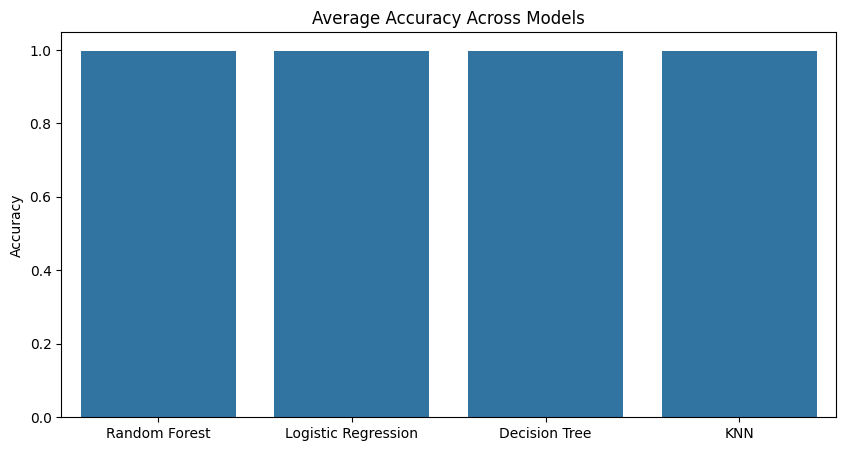

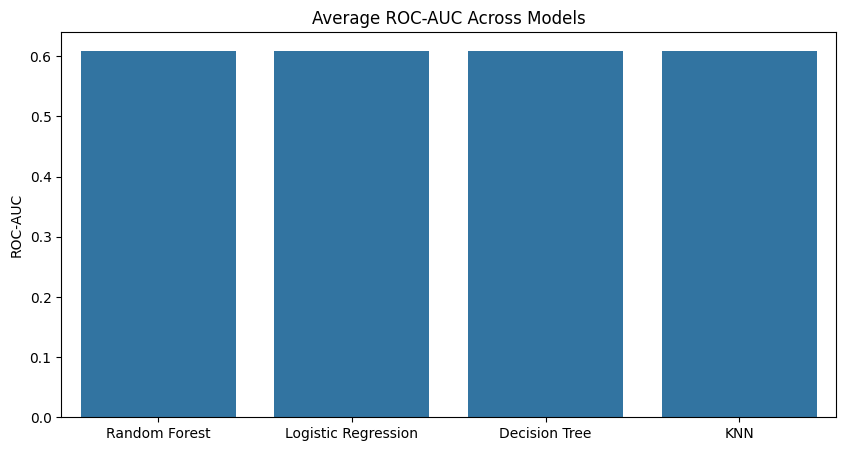


Detailed Classification Report for Random Forest (Last Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.73      0.81        98

    accuracy                           1.00     56961
   macro avg       0.96      0.87      0.91     56961
weighted avg       1.00      1.00      1.00     56961


Detailed Classification Report for Logistic Regression (Last Fold):


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.06      0.87      0.10        98

    accuracy                           0.97     56961
   macro avg       0.53      0.92      0.55     56961
weighted avg       1.00      0.97      0.99     56961


Detailed Classification Report for Decision Tree (Last Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.67      0.67        98

    accuracy                           1.00     56961
   macro avg       0.84      0.84      0.84     56961
weighted avg       1.00      1.00      1.00     56961


Detailed Classification Report for KNN (Last Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      0.04      0.08        98

    accuracy                           1.00     56961
   macro avg

In [ ]:
# Step 6: Visualize Results
# Accuracy Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(models.keys()), y=avg_accuracy)
plt.title('Average Accuracy Across Models')
plt.ylabel('Accuracy')
plt.show()

# ROC-AUC Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(models.keys()), y=avg_roc_auc)
plt.title('Average ROC-AUC Across Models')
plt.ylabel('ROC-AUC')
plt.show()

# Step 7: Display Classification Reports
# Classification Report for Logistic Regression
print("\nDetailed Classification Report for Random Forest (Last Fold):")
model = models['Random Forest']
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


# Classification Report for Logistic Regression
print("\nDetailed Classification Report for Logistic Regression (Last Fold):")
log_reg_model = models['Logistic Regression']
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
print(classification_report(y_test, y_pred_log_reg))

# Classification Report for Decision Tree
print("\nDetailed Classification Report for Decision Tree (Last Fold):")
dt_model = models['Decision Tree']
dt_model.fit(X_train, y_train) 
y_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

# Classification Report for KNN
print("\nDetailed Classification Report for KNN (Last Fold):")
knn_model = models['KNN']
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print(classification_report(y_test, y_pred_knn))


In [ ]:
# Dashboard
!pip install openpyxl

In [ ]:
# Save the processed data to an Excel file
data.to_excel('/content/processed_creditcard_data.xlsx', index=False)

In [ ]:
# Download the file to your local machine
files.download('/content/processed_creditcard_data.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Load your dataset
# Replace 'your_dataset.csv' with the actual dataset path
data = pd.read_csv('creditcard.csv')

# Define features (X) and target (y)
X = data.drop('Class', axis=1)  # Replace 'Class' with your target column name
y = data['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 1: Train and Save the Model and Scaler
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Save the model and scaler
joblib.dump(model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully.")

# Step 2: Define a function to preprocess the user input
def preprocess_input(user_input):
    # Load the scaler
    scaler = joblib.load('scaler.pkl')

    # Convert user input into a dataframe
    input_data = pd.DataFrame([user_input], columns=X_train.columns)

    # Scale the 'Time' and 'Amount' columns
    input_data[['Time', 'Amount']] = scaler.transform(input_data[['Time', 'Amount']])

    return input_data

# Step 3: Define a function to make a prediction
def predict_fraud(user_input):
    # Load the trained model
    model = joblib.load('random_forest_model.pkl')

    # Preprocess the user input
    preprocessed_input = preprocess_input(user_input)

    # Make the prediction using the model
    prediction = model.predict(preprocessed_input)

    # Return the prediction result
    return "Fraudulent Transaction" if prediction[0] == 1 else "Non-Fraudulent Transaction"

# Step 4: Get user input and make a prediction
user_input = [150000, -2.123, 0.345, -0.654, 0.567, 1.234, -0.987, 0.456, 0.652, -0.718, 1.385, 0.962, -0.616, 0.238, 0.2489, 0.456, 0.654, 0.567, 1.234, -0.956, 0.3155, 0.168, 0.652, -0.718, -0.123, 0.789, 0.4462,0.568, 1.205, 100.0]

# Call the prediction function
result = predict_fraud(user_input)
print(result)

Model and scaler saved successfully.
Non-Fraudulent Transaction
